# Scoring Client

Votre client souhaite mettre à disposition un tableau de bord à ses conseillers financiers indiquant diverses informations et indicateurs. 

Le but de ce projet est de montrer une première itération complète (ML + déploiement).

**Contexte du projet**

Le projet se découpe en 2 parties :

Partie 1 : Construction du modèle de scoring

Une démarche détaillée (les étapes, modèles préssentis à tester, les paramètres de performance utilisés) devra être présentée avant la réalisation pour validation.

Partie 2 : Mise à disposition via dashboard

**Le dashboard final doit remplir les attentes suivantes :**

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

Le focus ne doit pas être fait sur l'interprétation et une compréhension poussée des données (puisque certaines ont été anonymisées) mais sur la mise à disposition de celles-ci de manière fiable à un public non expert.


# Import

In [22]:
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# models
from sklearn.ensemble import RandomForestClassifier

# tuning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import pickle

# EDA

In [23]:
# display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [24]:
# view all info about data
def all_info(df):
    print("-------------Top-5--------------")
    print(df.head())
    print()
    print("-----------Information-----------")
    print(df.info())
    print()
    print("-----------Data Types-----------")
    print(df.dtypes)
    print()
    print("----------Missing value-----------")
    print(df.isnull().sum())
    print()
    print("----------Null value-----------")
    print(df.isna().sum())
    print()
    print("----------Shape of Data----------")
    print(df.shape)
    print("----------Duplicate----------")
    print(df.duplicated().sum())

In [25]:
# load dataset application_train.csv
df_train = pd.read_csv('data/application_train.csv')
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [26]:
all_info(df_train)

-------------Top-5--------------
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccom

In [27]:
# get numerical and categorical column
numeric_col=[col for col in df_train if df_train[col].dtype !="object" ]
categorical_col=[col for col in df_train if df_train[col].dtype=="object" ]
numeric_col.remove("TARGET")

print("Numerical col:",numeric_col)
print("Categorical col:",categorical_col)

Numerical col: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 

In [28]:
# sum of 0 & 1 in target
df_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

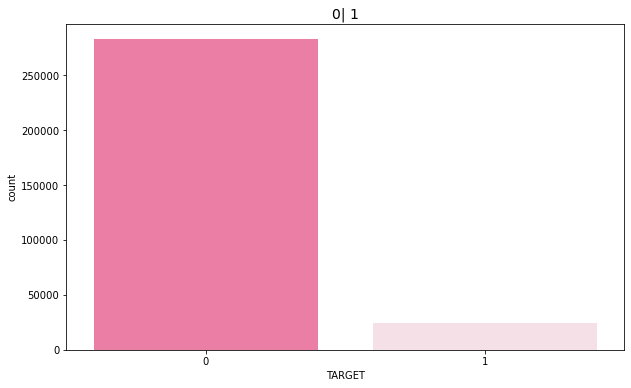

In [29]:
# target : "Target" / very unbalanced
plt.figure(figsize = (10,6))
plt.title('0| 1', fontsize=14)
sns.countplot(x="TARGET", data=df_train,  palette=['#FD6C9E',"#FADCE6"])
plt.show()

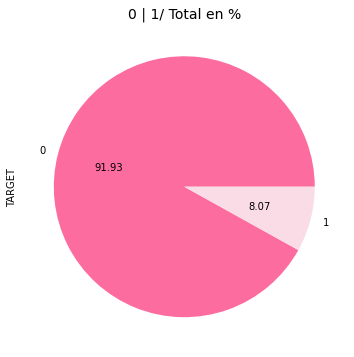

In [30]:
# target : "Target" / very unbalanced
plt.figure(figsize = (6,6))
plt.title('0 | 1/ Total en %', fontsize=14)
df_train['TARGET'].value_counts().plot(kind='pie',autopct="%.2f", colors = ['#FD6C9E', "#FADCE6"])
plt.show()

**Observations**
- Colonne cible : TARGET (1 > client avec difficultés de paiement / 0 > autre cas)
- Dataset déséquilibré : 0  > 282 686 (92%) / 1 > 24825 (8%)
- 0 duplicate
- Shape : 307 711 lignes x 122 colonnes
- Null value : 9 152 465
- Missing value : 9 152 465

**Cleaning**

Pour nettoyer les données, je décide de garder uniquement les colonnes dont j'aurais besoin pour l'application en ligne. Je supprime les NaN, il me reste donc quelques 200 000 lignes et 10 colonnes de données valides.

<AxesSubplot:>

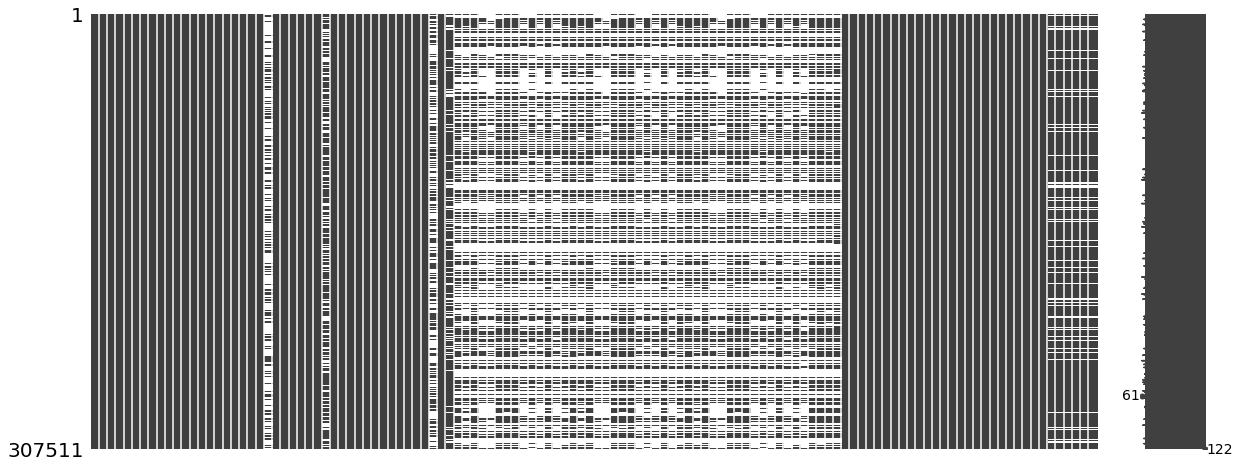

In [31]:
# view missing values
import missingno as mno
mno.matrix(df_train, figsize = (20, 8))

In [ ]:
# keep only columns where 60% or more valid data is available
#df=df.dropna(how='any',axis=1,thresh=df.shape[0]*0.6)

In [32]:
# keep only this columns
df = df_train.filter(['TARGET', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE','OCCUPATION_TYPE', 'AMT_CREDIT'], axis=1)

In [33]:
# data's shape
df.shape

(307511, 10)

In [98]:
# replace NaN by median on total_bedrooms
#df.fillna(df.mean(), inplace=True)

In [34]:
# drop NaN in dataframe
df.dropna(inplace=True)

In [35]:
# data's shape
df.shape

(211120, 10)

In [36]:
df

,TARGET,CODE_GENDER,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,DAYS_BIRTH,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,AMT_CREDIT
0,1,M,Single / not married,Secondary / secondary special,-9461,0,202500.0,Cash loans,Laborers,406597.5
1,0,F,Married,Higher education,-16765,0,270000.0,Cash loans,Core staff,1293502.5
2,0,M,Single / not married,Secondary / secondary special,-19046,0,67500.0,Revolving loans,Laborers,135000.0
3,0,F,Civil marriage,Secondary / secondary special,-19005,0,135000.0,Cash loans,Laborers,312682.5
4,0,M,Single / not married,Secondary / secondary special,-19932,0,121500.0,Cash loans,Core staff,513000.0
...,...,...,...,...,...,...,...,...,...,...
307504,0,F,Separated,Secondary / secondary special,-16705,0,153000.0,Cash loans,Sales staff,331920.0
307506,0,M,Separated,Secondary / secondary special,-9327,0,157500.0,Cash loans,Sales staff,254700.0
307508,0,F,Separated,Higher education,-14966,0,153000.0,Cash loans,Managers,677664.0
307509,1,F,Married,Secondary / secondary special,-11961,0,171000.0,Cash loans,Laborers,370107.0


# Preprocessing & pipeline

In [37]:
# splitting the training data into training and validation sets
X = df.drop(['TARGET'], axis=1)
y = df['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [38]:
# creating a preprocessor to transform categoricals / numericals column
categoricals_col = list(X_train.select_dtypes('object').columns)
numericals_col= list(X_train.select_dtypes(exclude=['object']).columns)

In [41]:
# col transformer (encoding / scaling)
col_transformer = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categoricals_col),
    ('scaler', MinMaxScaler(), numericals_col)
])

In [43]:
# create pipeline
pipeline = imbpipeline([
    ('col_transformer', col_transformer),
    ('smote', SMOTE(random_state=11)),
    ('model', RandomForestClassifier(max_depth = 10,
                                     min_samples_leaf = 3,
                                     min_samples_split = 4,
                                     n_estimators = 200))

])

In [44]:
# fit training data
pipeline.fit(X_train,y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CODE_GENDER',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_CONTRACT_TYPE',
                                                   'OCCUPATION_TYPE']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['DAYS_BIRTH', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT'])])),
                ('smote', SMOTE(random_state=11)),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
      

In [35]:
# save pipeline to a binary pickle file
# joblib.dump(pipeline, 'model.pkl')

# load pickle
#loaded_model = joblib.load('model.pkl')

In [45]:
# check out predicted results using the validation dataset
pipeline_preds = pipeline.predict(X_val)

val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)
val_confusion_matrix = confusion_matrix(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}')
print(f'Confusion Matrix: \n{val_confusion_matrix}')

Accuracy Score: 0.6851269420234938
ROC AUC Score: 0.5869283991383445
Confusion Matrix: 
[[33979 14135]
 [ 2484  2182]]


In [47]:
# print classification report
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.71      0.80     48114
           1       0.13      0.47      0.21      4666

    accuracy                           0.69     52780
   macro avg       0.53      0.59      0.51     52780
weighted avg       0.86      0.69      0.75     52780



<AxesSubplot:>

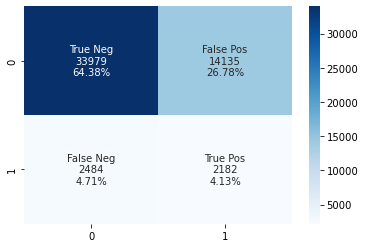

In [48]:
# confusion matrix
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in val_confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in val_confusion_matrix.flatten()/np.sum(val_confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(val_confusion_matrix, annot=labels, fmt='', cmap='Blues')